Device:  cuda
Current working directory:  /home/guido/github/physioex-private/papers/icml
torch.Size([70000, 1000]) torch.Size([70000])


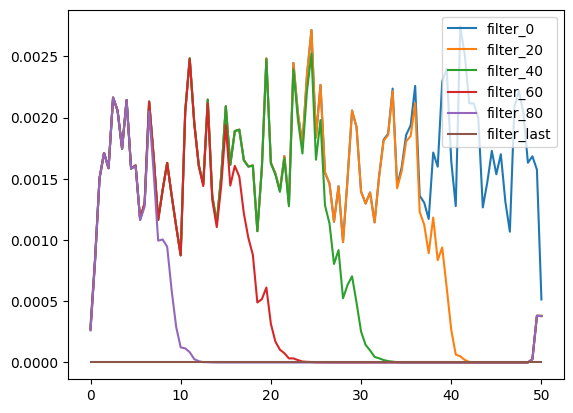

In [5]:
import torch
import torch.nn as nn

from matplotlib import pyplot as plt

from tqdm.autonotebook import tqdm                   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print( "Device: ", device ) 

import os
os.chdir( "/home/guido/github/physioex-private/papers/icml/" )

print( "Current working directory: ", os.getcwd() )

from src.model import TimeModule
from collections import OrderedDict
fn = TimeModule.load_from_checkpoint( "synt_model/checkpoint/epoch=4-step=7628-val_acc=0.96.ckpt" ).eval()
fn = nn.Sequential( OrderedDict( [ ( "fn", fn ), ("softmax", nn.Softmax(dim=1)) ] ) ).to(device)

from src.synt_data import SyntDataset, CLASS_DESC
data = SyntDataset(CLASS_DESC)


from src.SpectralGradients import SpectralGradients
SG = SpectralGradients( f = fn, fs = 100, Q = 5, nperseg = 200, noverlap = 100)

# plot the SG of a random sample
SG.plot_power_spectral_density( torch.rand(1, 1, 1000) )

SG = SG.to(device) 

from torch.utils.data import DataLoader
import numpy as np

from src.IntegratedGradients import IntegratedGradients

IG = IntegratedGradients( f = fn, n_points = 100, baseline = 0).to(device)


In [6]:

loader = DataLoader(data, batch_size=256, num_workers=8)

sg , y, x, ig = [], [], [], []
for i, (x_, _) in enumerate(tqdm(loader)):
    ig.append( IG( x_.to(device) ).detach().cpu().numpy() )
    y.append ( fn(x_.to(device)).detach().cpu().numpy() )
    sg.append( SG( x_.to(device) ).detach().cpu().numpy() )
    x.append( x_.numpy() )
    break

ig = np.concatenate( ig, axis = 0 )    
sg = np.concatenate( sg, axis = 0 )
y = np.concatenate( y, axis = 0 )
x = np.concatenate( x, axis = 0 )

#data = np.load( "synt_model/convnet/importances/highest/importances.npz")
#sg, y = data["sg"], data["y"]

sg.shape, ig.shape, y.shape


  0%|          | 0/274 [06:35<?, ?it/s]


((256, 7, 100, 1000), (256, 7, 1000), (256, 7))

In [7]:
y_preds = np.argmax( y, axis = 1 ).astype( int )

importances, ig_importances,  classes, signals = [], [], [], []
for c in  np.unique( y_preds ) :
    indexes = np.where( y_preds == c )[0]
    
    signals.append( x[indexes] )
    importances.append( sg[indexes] )
    ig_importances.append( ig[indexes] )
    classes.append( c  )

print( "Classes: ", classes )    

Classes:  [0, 1, 2, 3, 4, 5, 6]


Class:  0
Signal shape:  (37, 101)
Importance shape:  (100, 1000)
Sum importance shape:  (100,)
Time importance shape:  (1000,)
IG importance shape:  (1000,)
Class:  1
Signal shape:  (42, 101)
Importance shape:  (100, 1000)
Sum importance shape:  (100,)
Time importance shape:  (1000,)
IG importance shape:  (1000,)
Class:  2
Signal shape:  (41, 101)
Importance shape:  (100, 1000)
Sum importance shape:  (100,)
Time importance shape:  (1000,)
IG importance shape:  (1000,)
Class:  3
Signal shape:  (30, 101)
Importance shape:  (100, 1000)
Sum importance shape:  (100,)
Time importance shape:  (1000,)
IG importance shape:  (1000,)
Class:  4
Signal shape:  (30, 101)
Importance shape:  (100, 1000)
Sum importance shape:  (100,)
Time importance shape:  (1000,)
IG importance shape:  (1000,)
Class:  5
Signal shape:  (36, 101)
Importance shape:  (100, 1000)
Sum importance shape:  (100,)
Time importance shape:  (1000,)
IG importance shape:  (1000,)


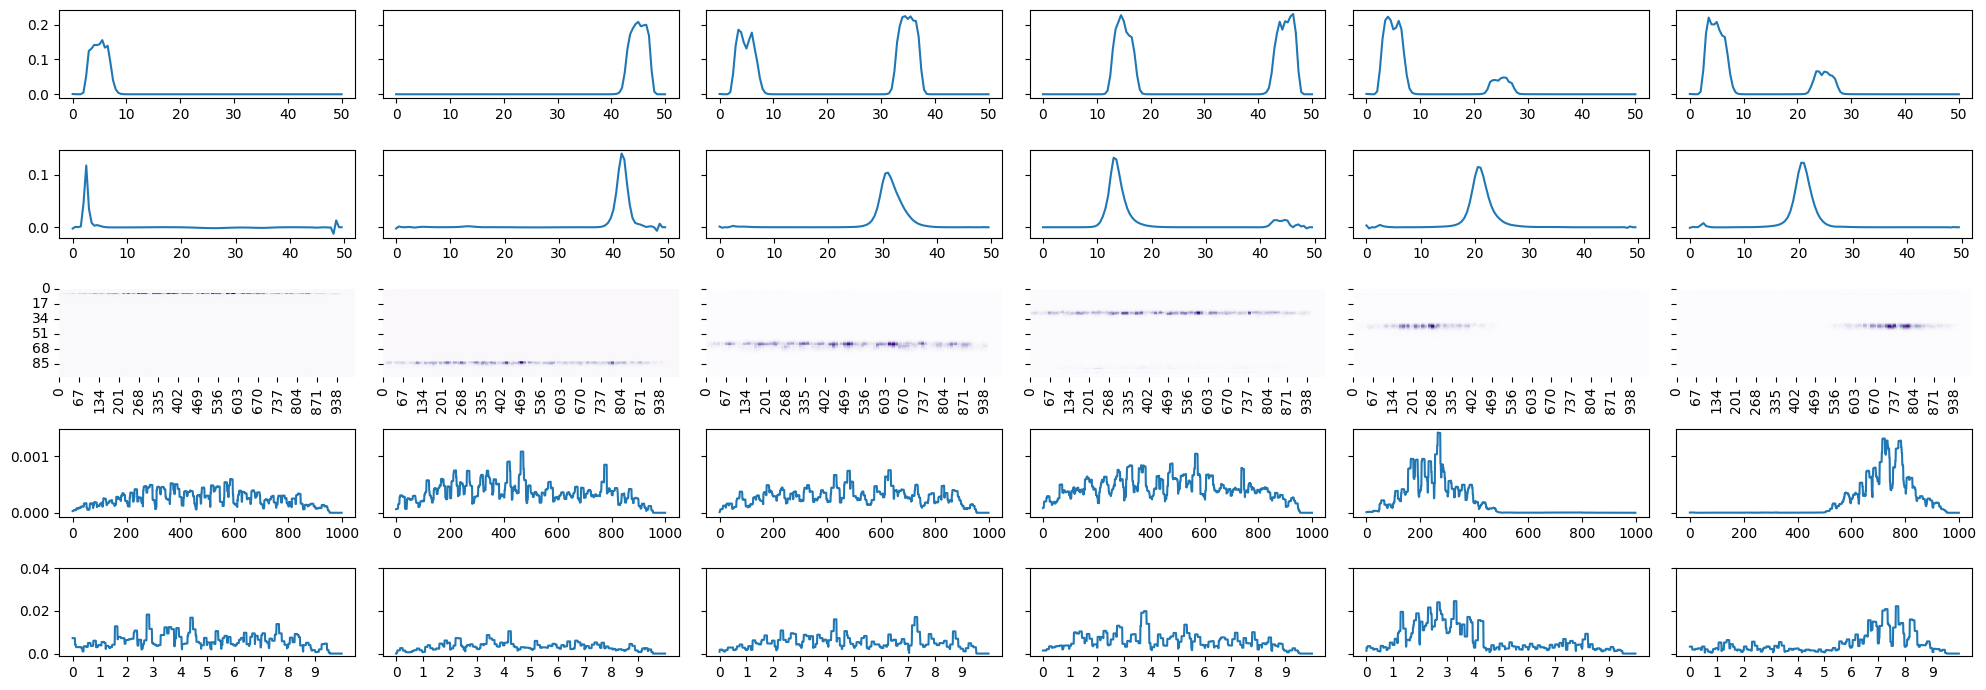

In [53]:
import seaborn as sns
from scipy.signal import welch
import torch.nn as nn

fig, axes = plt.subplots( 5, len(classes) - 1, figsize = (20, 7), sharex= "row", sharey = "row" )

min_val = float('inf')
max_val = float('-inf')

for c in classes:
    if c == classes[-1]:
        break

    importance = importances[c][:, c].mean(axis=0)
    min_val = min(min_val, importance.min())
    max_val = max(max_val, importance.max())

# compute the max absolute value
#max_val = max( abs(min_val), abs(max_val) )
#min_val = -max_val

for c in classes:
    if c == classes[-1]:
        break

    print( "Class: ", c )
    importance = importances[c][:, c].mean( axis = 0 )
    
    f, psd = welch( signals[c], fs = 100, nperseg = 200, noverlap = 100, axis = -1 )
   
    sum_importance = importance.sum( axis = 1).reshape(-1)
    
    print( "Signal shape: ", psd.shape)
    print( "Importance shape: ", importance.shape)    
    print( "Sum importance shape: ", sum_importance.shape) 
   
    sns.lineplot( x = f, y = psd.mean( axis = 0 ), ax = axes[0, c] )

    sns.lineplot( x = np.arange(0, 50, 0.5), y = sum_importance, ax = axes[1, c] )
    plt.xticks( np.arange( 0, 50, 5), np.arange( 0, 50, 5) )
    
    # the heatmap is 100 x 1000
    # we need to use a MaxPooling with replecement to smooth the heatmap
    pool = nn.MaxPool1d( kernel_size = (10), stride = 1, padding = 5)
    importance = torch.tensor( importance ).unsqueeze(0)
    importance = pool( importance ).squeeze(0).numpy()
    
    # weight the importance with the sum_importance
    importance = importance * sum_importance.reshape(-1, 1)
    importance = importance[:, :1000]
    
    sns.heatmap( importance, cmap = "Purples", ax = axes[2, c], cbar = False )
    
    # the y axis is composed by 100 Freqs ( 0-50Hz with 0.5 Hz resolution )
    plt.yticks( np.arange( 0, 100, 10), np.arange( 0, 50, 5) )
    plt.xticks( np.arange( 0, 1000, 100), np.arange( 0, 10, 1) )
    
    
    # plot the SG in time domain
    time_importance = importance.sum( axis = 0 )
    print( "Time importance shape: ", time_importance.shape)
    sns.lineplot( x = np.arange(0, 1000, 1), y = time_importance, ax = axes[3, c] )
    plt.xticks( np.arange( 0, 100, 10), np.arange( 0, 10, 1) )
    plt.yticks( np.arange( 0, 0.05, 0.02), np.arange( 0, 0.05, 0.02) )
    
    # plot the IG
    
    ig_importance = ig_importances[c][:, c].mean( axis = 0 )
    ig_importance = torch.tensor( ig_importance ).unsqueeze(0)
    ig_importance = pool( ig_importance ).squeeze(0).numpy()[:1000]
    
    print( "IG importance shape: ", ig_importance.shape)
    
    sns.lineplot( x = np.arange(0, 100, 0.1), y = ig_importance, ax = axes[4, c] )
    plt.xticks( np.arange( 0, 100, 10), np.arange( 0, 10, 1) )
    plt.yticks( np.arange( 0, 0.05, 0.02), np.arange( 0, 0.05, 0.02) )

plt.tight_layout()
plt.show()
plt.close()

<Axes: >

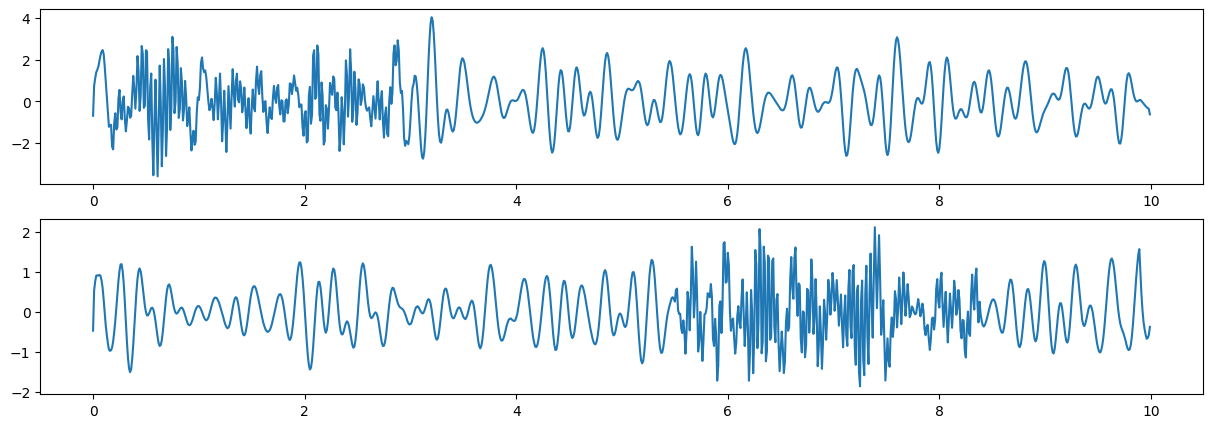

In [15]:

class_4_in = signals[4][0]
class_5_in = signals[5][2]

fig, axes = plt.subplots( 2, 1, figsize = (15, 5) )

sns.lineplot( x = np.arange(0, 10, 0.01), y = class_4_in, ax = axes[0] )
sns.lineplot( x = np.arange(0, 10, 0.01), y = class_5_in, ax = axes[1] )


Class:  4
Signal shape:  (30, 101)
Importance shape:  (100, 1000)
Sum importance shape:  (100,)
Class:  5
Signal shape:  (36, 101)
Importance shape:  (100, 1000)
Sum importance shape:  (100,)


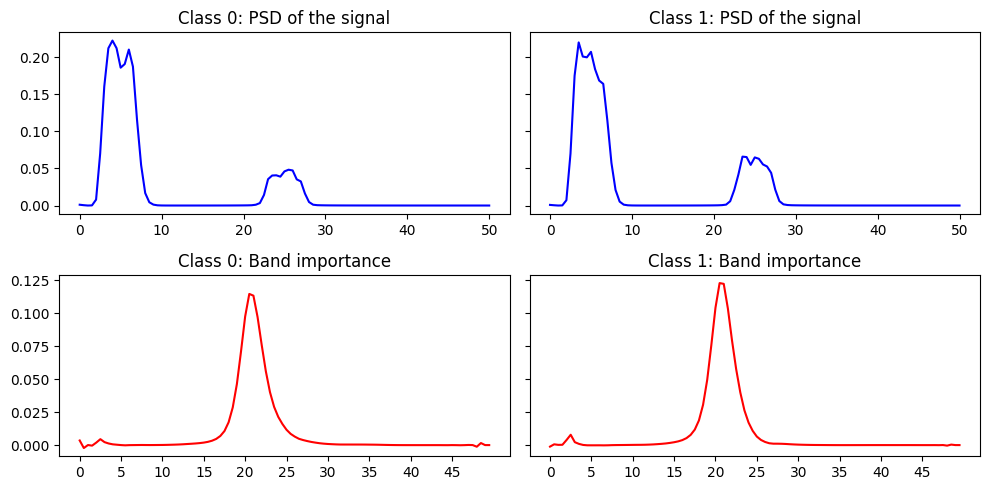

In [21]:
import seaborn as sns
from scipy.signal import welch
import torch.nn as nn

fig, axes = plt.subplots( 2, 2, figsize = (10, 5), sharex= "row", sharey = "row" )

min_val = float('inf')
max_val = float('-inf')

for c in classes:
    if c == classes[-1]:
        break

    importance = importances[c][:, c].mean(axis=0)
    min_val = min(min_val, importance.min())
    max_val = max(max_val, importance.max())

# compute the max absolute value
#max_val = max( abs(min_val), abs(max_val) )
#min_val = -max_val

for c in classes:
    if c != 4 and c != 5:
        continue

    print( "Class: ", c )
    importance = importances[c][:, c].mean( axis = 0 )
    
    axes[0, c - 4].set_title( f"Class {c-4}: PSD of the signal" )
    f, psd = welch( signals[c], fs = 100, nperseg = 200, noverlap = 100, axis = -1 )
   
    sum_importance = importance.sum( axis = 1).reshape(-1)
    
    print( "Signal shape: ", psd.shape)
    print( "Importance shape: ", importance.shape)    
    print( "Sum importance shape: ", sum_importance.shape) 

    axes[1, c - 4].set_title( f"Class {c-4}: Band importance" )   
    sns.lineplot( x = f, y = psd.mean( axis = 0 ), ax = axes[0, c - 4], color = "blue" )

    sns.lineplot( x = np.arange(0, 50, 0.5), y = sum_importance, ax = axes[1, c - 4], color = "red" )
    plt.xticks( np.arange( 0, 50, 5), np.arange( 0, 50, 5) )
    

plt.tight_layout()
plt.show()
plt.close()

Class:  4
Signal shape:  (36, 101)
Importance shape:  (100, 1000)
Sum importance shape:  (100,)
Class:  5
Signal shape:  (36, 101)
Importance shape:  (100, 1000)
Sum importance shape:  (100,)


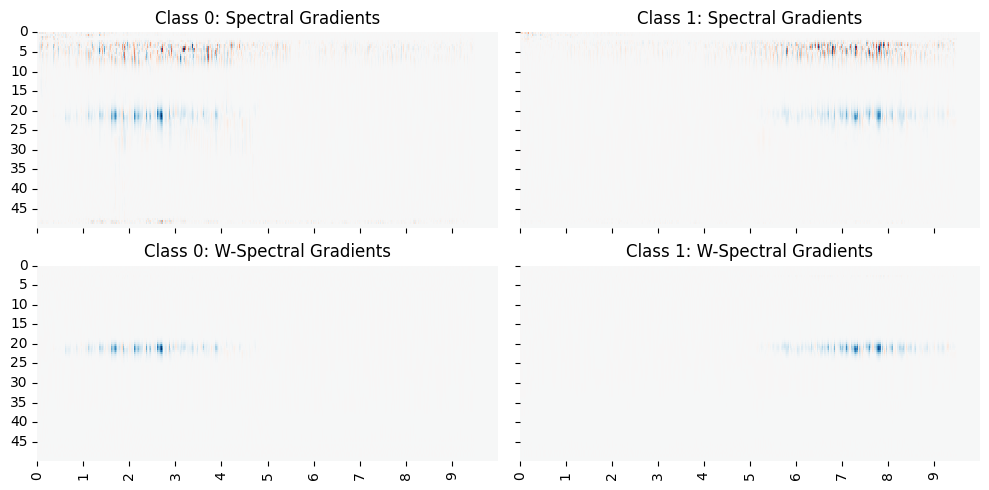

In [39]:
import seaborn as sns
from scipy.signal import welch
import torch.nn as nn

fig, axes = plt.subplots( 2, 2, figsize = (10, 5), sharex= "col", sharey = "row" )

min_val = float('inf')
max_val = float('-inf')

for c in classes:
    if c != 4 and c != 5:
        continue
    
    importance = importances[c][:, c].mean(axis=0)
    
min_val = min(min_val, importance.min())
max_val = max(max_val, importance.max())

# compute the max absolute value
#max_val = max( abs(min_val), abs(max_val) )
#min_val = -max_val

for c in classes:
    if c != 4 and c != 5:
        continue

    print( "Class: ", c )
    importance = importances[c][:, c].mean( axis = 0 )
    
    axes[0, c - 4].set_title( f"Class {c-4}: Spectral Gradients" )
    #f, psd = welch( signals[c], fs = 100, nperseg = 200, noverlap = 100, axis = -1 )
   
    sum_importance = importance.sum( axis = 1).reshape(-1)
    
    print( "Signal shape: ", psd.shape)
    print( "Importance shape: ", importance.shape)    
    print( "Sum importance shape: ", sum_importance.shape) 

    axes[1, c - 4].set_title( f"Class {c-4}: W-Spectral Gradients" )   
    max_val = max( abs(importance.min()), abs(importance.max()) )
    sns.heatmap( importance, cmap = "RdBu", ax = axes[0, c-4], cbar = False, vmax = max_val, vmin = -max_val )
    axes[0, c-4].set_xticks( np.arange( 0, 1000, 100) )
    
    
    importance = importance * sum_importance.reshape(-1, 1)
    max_val = max( abs(importance.min()), abs(importance.max()) )
    
    sns.heatmap( importance, cmap = "RdBu", ax = axes[1, c-4], cbar = False, vmax=max_val, vmin=-max_val )  
    
    # plot the xticks every 10 seconds ( fs = 100 Hz )
    axes[1, c-4].set_xticks( np.arange( 0, 1000, 100) )
    # label the xticks with the seconds
    axes[1, c-4].set_xticklabels( np.arange( 0, 10, 1) )
    
    # plot the yticks every 5 Hz, Hz resolution is 0.5 Hz [0, 50]Hz
    axes[1, c-4].set_yticks( np.arange( 0, 100, 10) )
    # label the yticks with the Hz 
    axes[1, c-4].set_yticklabels( np.arange( 0, 50, 5) )
    
    axes[0, c-4].set_yticks( np.arange( 0, 100, 10) )
    # label the yticks with the Hz 
    axes[0, c-4].set_yticklabels( np.arange( 0, 50, 5) )
    

plt.tight_layout()
plt.show()
plt.close()

Class:  4
Max importance:  0.11450486
Time importance shape:  (1000,)
IG importance shape:  (1000,)
Class:  5
Max importance:  0.12271725
Time importance shape:  (1000,)
IG importance shape:  (1000,)


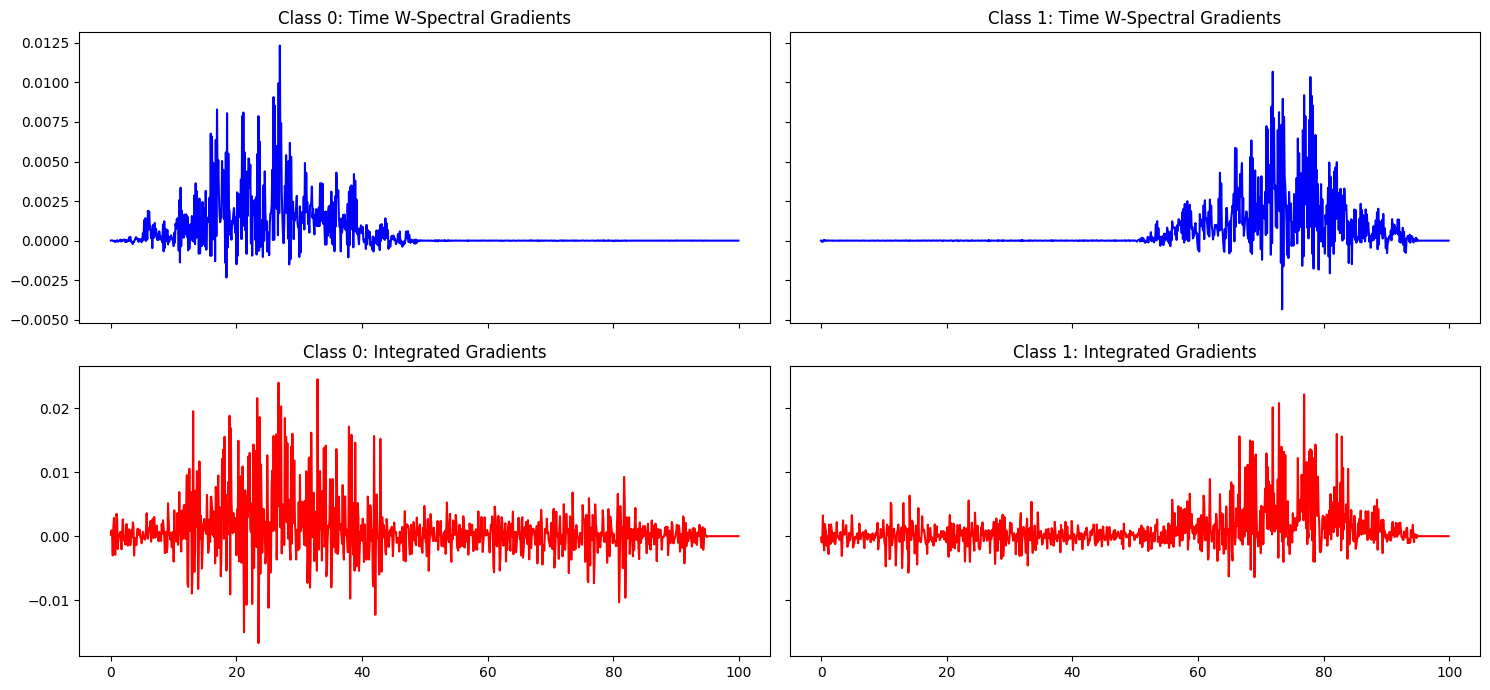

In [55]:
import seaborn as sns
from scipy.signal import welch
import torch.nn as nn

fig, axes = plt.subplots( 2, 2, figsize = (15, 7), sharex= "col", sharey = "row" )

min_val = float('inf')
max_val = float('-inf')

for c in classes:
    if c == classes[-1]:
        break

    importance = importances[c][:, c].mean(axis=0)
    min_val = min(min_val, importance.min())
    max_val = max(max_val, importance.max())

# compute the max absolute value
#max_val = max( abs(min_val), abs(max_val) )
#min_val = -max_val

for c in classes:
    if c != 4 and c != 5:
        continue
    
    print( "Class: ", c )
    importance = importances[c][:, c].mean( axis = 0 )
    
    sum_importance = importance.sum( axis = 1).reshape(-1)
    
    # weight the importance with the sum_importance
    importance = importance * sum_importance.reshape(-1, 1)
    
    # plot the SG in time domain
    time_importance = importance.sum( axis = 0 )
    time_importance = time_importance / max( sum_importance )
    print( "Max importance: ", sum_importance.max() )
    print( "Time importance shape: ", time_importance.shape)
    axes[0, c-4].set_title( f"Class {c-4}: Time W-Spectral Gradients" )
    sns.lineplot( x = np.arange(0, 100, 0.1), y = time_importance, ax = axes[0, c-4], color= "blue" )
    
    # plot the IG
    
    ig_importance = ig_importances[c][:, c].mean( axis = 0 )
    
    print( "IG importance shape: ", ig_importance.shape)
    axes[1, c-4].set_title( f"Class {c-4}: Integrated Gradients")    
    sns.lineplot( x = np.arange(0, 100, 0.1), y = ig_importance, ax = axes[1, c-4], color= "red" )

plt.tight_layout()
plt.show()
plt.close()